#Mengimpor libraries

In [1]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

In [3]:
# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

In [4]:

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)


2.17.0


#Data Loading

In [6]:
# Import module yang disediakan google colab untuk kebutuhan upload file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"umbusuryamktabuk","key":"46e7ce2358bf2780f5e88db4f005613e"}'}

In [7]:

!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
100% 346M/346M [00:17<00:00, 25.0MB/s]
100% 346M/346M [00:17<00:00, 21.0MB/s]


In [8]:
!unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [9]:
# Path dataset
train_dir = "seg_train/seg_train"
test_dir = "seg_test/seg_test"

# Direktori baru untuk dataset gabungan
combined_dir = "intel_image/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(train_dir):
    category_dir = os.path.join(train_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

# Salin file dan folder dari test
for category in os.listdir(test_dir):
    category_dir = os.path.join(test_dir, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)


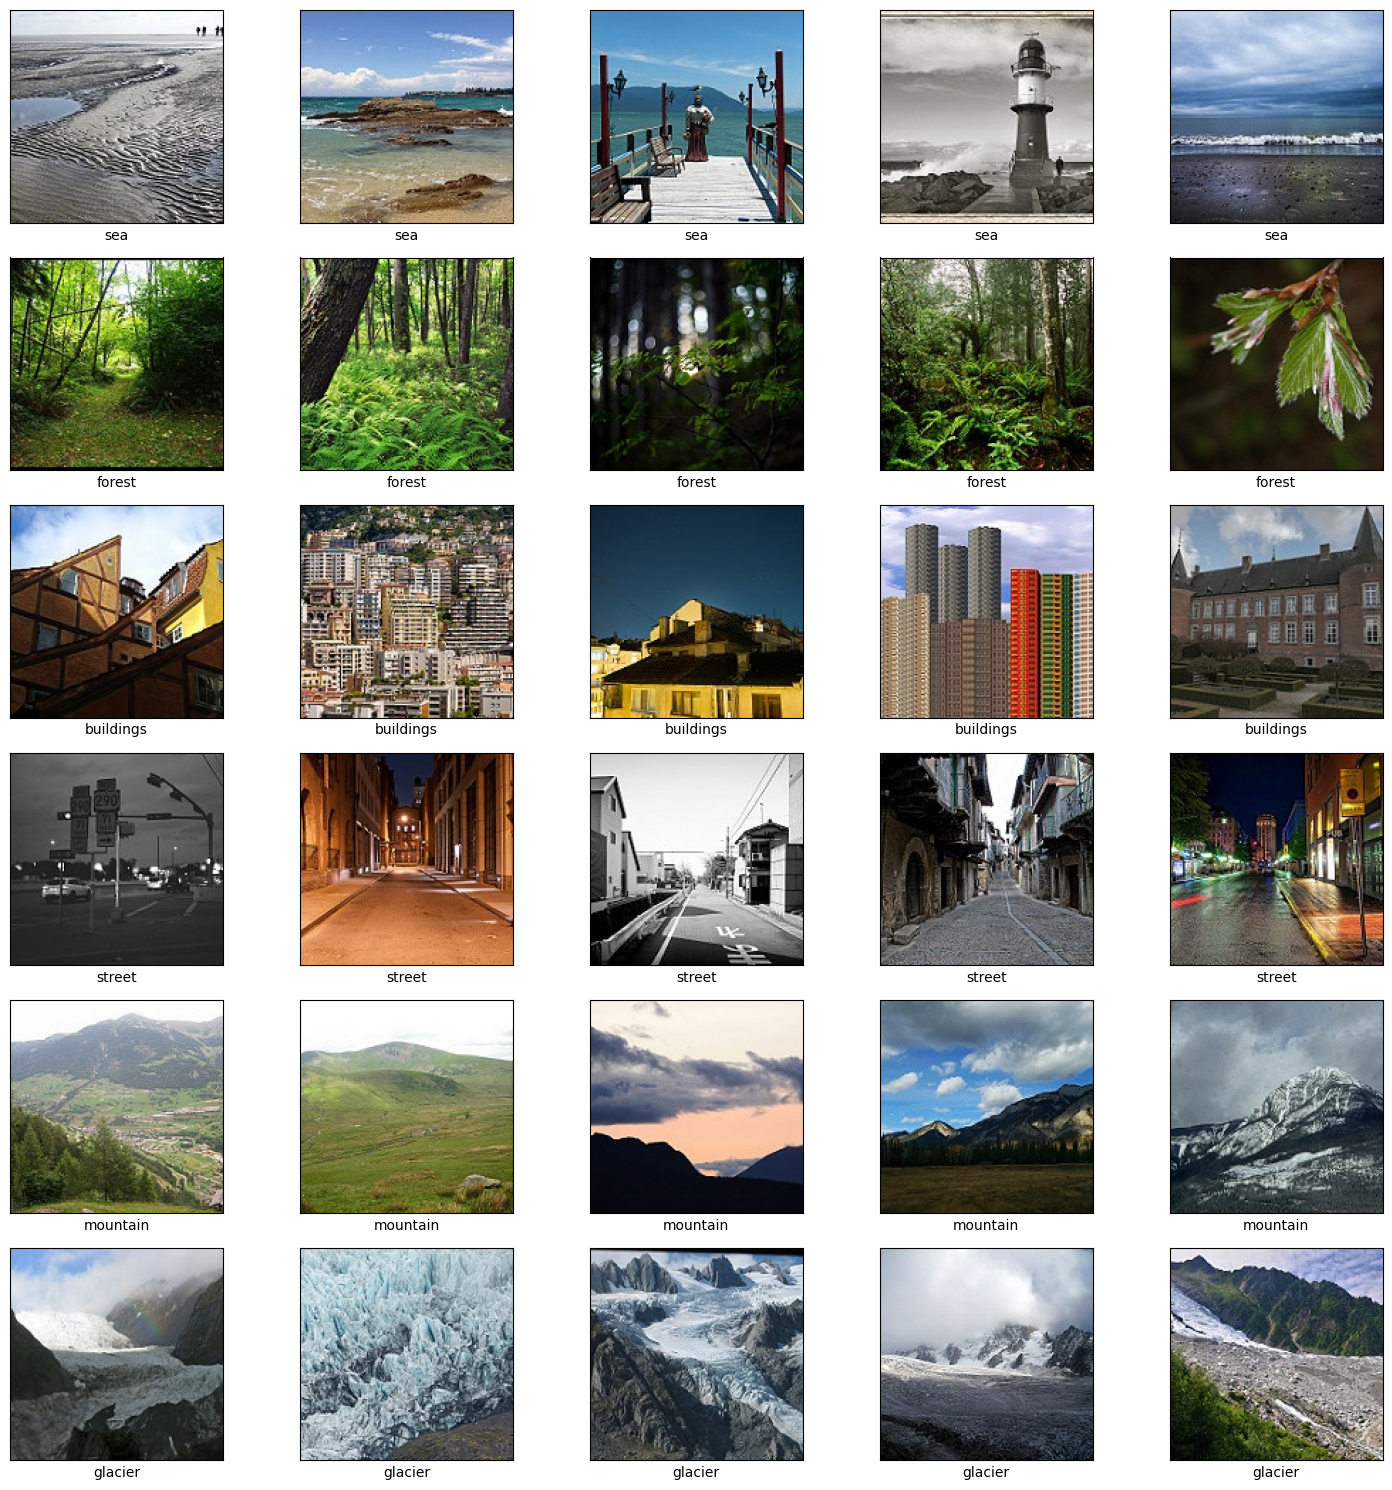

In [10]:
# Mengisi kamus yang menyimpan gambar dari tiap kategori
image_data = {}

# Tentukan path yang benar untuk dataset
path_sub = os.path.join("intel_image/dataset")

# Mengisi kamus dengan file gambar dari tiap kategori
for i in os.listdir(path_sub):
    image_data[i] = os.listdir(os.path.join(path_sub, i))

# Menampilkan gambar secara acak dari setiap kelas di dataset
fig, axs = plt.subplots(len(image_data.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(image_data[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path).convert("RGB")  # Konversi ke RGB karena dataset berwarna
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()


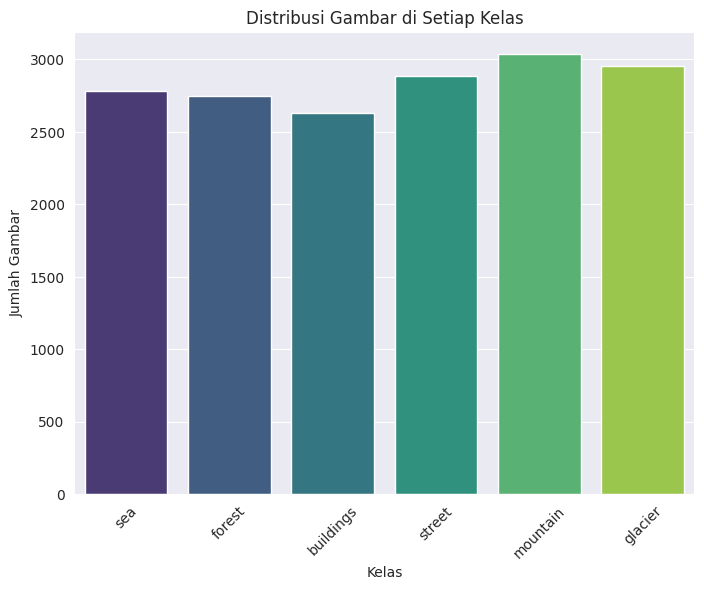

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define source path
image_path = "intel_image/dataset/"

# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(image_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Create a dataframe with the collected data
distribution_data = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot the distribution of images across the classes
plt.figure(figsize=(8, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x='labels', data=distribution_data, palette="viridis")
plt.title("Distribusi Gambar di Setiap Kelas")
plt.xlabel("Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()


#Data Augmentation

In [12]:
import cv2
import random
import os
import numpy as np
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.transform import rotate, warp, AffineTransform
from skimage.exposure import adjust_gamma

# Fungsi untuk rotasi berlawanan arah jarum jam
def anticlockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    sudut = random.randint(0, 180)
    return rotate(img, sudut)

# Fungsi untuk rotasi searah jarum jam
def clockwise_rotation(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    sudut = random.randint(0, 180)
    return rotate(img, -sudut)

# Fungsi untuk membalik gambar secara vertikal dari atas ke bawah
def flip_up_down(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    return np.flipud(img)

# Fungsi untuk memberikan efek peningkatan kecerahan pada gambar
def add_brightness(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img = adjust_gamma(img, gamma=0.5, gain=1)
    return img

# Fungsi untuk memberikan efek blur pada gambar
def blur_image(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    return cv2.GaussianBlur(img, (9,9),0)

# Fungsi untuk memberikan efek pergeseran acak pada gambar
def sheared(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    transform = AffineTransform(shear=0.2)
    shear_image = warp(img, transform, mode='wrap')
    return shear_image

# Fungsi untuk melakukan pergeseran melengkung pada gambar
def warp_shift(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    transform = AffineTransform(translation=(0,40))
    warp_image = warp(img, transform, mode="wrap")
    return warp_image

# Variabel transformasi
transformations = {
    'rotate anticlockwise': anticlockwise_rotation,
    'rotate clockwise': clockwise_rotation,
    'flip up down': flip_up_down,
    'add brightness': add_brightness,
    'blurring image': blur_image,
    'sheared image': sheared,
    'warp shift': warp_shift
}

# Dataset Intel Image Classification
dataset_dirs = [
    '/content/intel_image/dataset/buildings',
    '/content/intel_image/dataset/forest',
    '/content/intel_image/dataset/glacier',
    '/content/intel_image/dataset/mountain',
    '/content/intel_image/dataset/sea',
    '/content/intel_image/dataset/street'
]

# Loop untuk menerapkan augmentasi pada setiap kategori dataset
for dataset_dir in dataset_dirs:
    images = []

    # Membaca gambar dari folder dan menambahkan ke list "images"
    for im in os.listdir(dataset_dir):
        images.append(os.path.join(dataset_dir, im))

    images_to_generate = 250  # Jumlah gambar augmentasi yang dihasilkan
    i = 1

    while i <= images_to_generate:
        image = random.choice(images)
        try:
            original_image = imread(image)
            transformed_image = None
            n = 0  # Iterasi untuk menentukan jumlah transformasi yang diterapkan
            transformation_count = random.randint(1, len(transformations))  # Pilih jumlah transformasi acak

            while n < transformation_count:
                key = random.choice(list(transformations))  # Pilih transformasi acak
                transformed_image = transformations[key](original_image)
                n += 1

            # Simpan gambar augmentasi
            new_image_path = os.path.join(dataset_dir, f"augmented_image_{i}.jpg")
            transformed_image = img_as_ubyte(transformed_image)  # Konversi gambar ke byte
            cv2.imwrite(new_image_path, transformed_image)  # Simpan hasil augmentasi
            i += 1
        except Exception as e:
            print(f'Could not process {image}: {e}, skipping it.')

print("Augmentasi selesai!")


Augmentasi selesai!


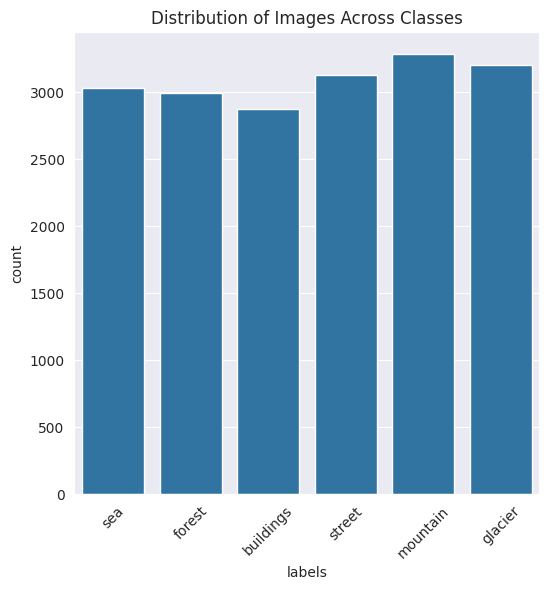

In [13]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define source path
lung_path = "/content/intel_image/dataset"

# Create lists to store filenames, filepaths, and labels
file_name = []
labels = []
full_path = []

# Loop through all the images in the dataset and store the path, filename, and label (based on folder name)
for path, subdirs, files in os.walk(lung_path):
    for name in files:
        if name.endswith(('.png', '.jpg', '.jpeg')):  # Ensure only image files are processed
            full_path.append(os.path.join(path, name))  # Full file path
            labels.append(os.path.basename(path))  # Folder name as label
            file_name.append(name)  # File name

# Create a DataFrame to organize the data
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot the distribution of images across the classes
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
plot_data = sns.countplot(x=distribution_train['labels'])
plt.title("Distribution of Images Across Classes")
plt.xticks(rotation=45)
plt.show()


In [14]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
import shutil

# Panggil variabel mypath yang menampung folder dataset gambar
mypath = '/content/intel_image/dataset'

file_name = []
labels = []
full_path = []

# Looping untuk mengambil path, nama file, dan label dari folder dataset
for path, subdirs, files in os.walk(mypath):
    for name in files:
        if name.endswith(('.png', '.jpg', '.jpeg')):
            full_path.append(os.path.join(path, name))
            labels.append(os.path.basename(path))
            file_name.append(name)

# Membuat dataframe dari data path dan label yang telah diambil
df = pd.DataFrame({"path": full_path, "file_name": file_name, "labels": labels})

# Melihat jumlah data gambar pada masing-masing label
print(df.groupby(['labels']).size())



labels
buildings    2878
forest       2995
glacier      3207
mountain     3287
sea          3034
street       3133
dtype: int64


In [15]:
# Variabel untuk pemisahan data
X = df['path']
y = df['labels']

# Split dataset menjadi training dan testing (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=300)

# Membuat dataframe untuk training dan testing set
df_tr = pd.DataFrame({'path': X_train, 'labels': y_train, 'set': 'train'})
df_te = pd.DataFrame({'path': X_test, 'labels': y_test, 'set': 'test'})

# Menampilkan ukuran data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))



train size 14827
test size 3707


In [16]:
# Gabungkan dataframe training dan testing
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))

# Path dataset asli dan folder untuk menyimpan dataset yang sudah di-split
datasource_path = "/content/intel_image/dataset"
dataset_path = "Final-dataset/"




set    labels   
test   buildings     646
       forest        560
       glacier       644
       mountain      671
       sea           587
       street        599
train  buildings    2232
       forest       2435
       glacier      2563
       mountain     2616
       sea          2447
       street       2534
dtype: int64 


                                                   path     labels    set
11603         /content/intel_image/dataset/sea/3615.jpg        sea  train
1566   /content/intel_image/dataset/buildings/12939.jpg  buildings  train
5378    /content/intel_image/dataset/mountain/11864.jpg   mountain  train
12084        /content/intel_image/dataset/sea/22326.jpg        sea  train
12239     /content/intel_image/dataset/forest/15798.jpg     forest  train


In [17]:
# Looping untuk memindahkan file ke folder training dan testing yang sesuai
for index, row in tq(df_all.iterrows(), total=len(df_all)):
    file_path = row['path']

    # Pastikan folder tujuan sudah ada, jika tidak, buat folder tersebut
    dest_dir = os.path.join(dataset_path, row['set'], row['labels'])
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # Tentukan tujuan file
    destination_file_name = os.path.basename(file_path)
    file_dest = os.path.join(dest_dir, destination_file_name)

    # Salin file dari sumber ke tujuan
    if not os.path.exists(file_dest):
        shutil.copy2(file_path, file_dest)

print("Data splitting dan penyimpanan selesai.")


100%|██████████| 18534/18534 [00:05<00:00, 3483.21it/s]

Data splitting dan penyimpanan selesai.


#Image Data Generator

In [18]:
import os

# Define TRAIN_DIR and TEST_DIR
TRAIN_DIR = '/content/Final-dataset/train'
TEST_DIR = '/content/Final-dataset/test'

# Define sub-directory paths for each class
train_buildings = os.path.join(TRAIN_DIR, 'buildings')
train_forest = os.path.join(TRAIN_DIR, 'forest')
train_glacier = os.path.join(TRAIN_DIR, 'glacier')
train_mountain = os.path.join(TRAIN_DIR, 'mountain')
train_sea = os.path.join(TRAIN_DIR, 'sea')
train_street = os.path.join(TRAIN_DIR, 'street')

test_buildings = os.path.join(TEST_DIR, 'buildings')
test_forest = os.path.join(TEST_DIR, 'forest')
test_glacier = os.path.join(TEST_DIR, 'glacier')
test_mountain = os.path.join(TEST_DIR, 'mountain')
test_sea = os.path.join(TEST_DIR, 'sea')
test_street = os.path.join(TEST_DIR, 'street')

# Create lists of train and test directories
train_dirs = [train_buildings, train_forest, train_glacier, train_mountain, train_sea, train_street]
test_dirs = [test_buildings, test_forest, test_glacier, test_mountain, test_sea, test_street]

# Print total number of images in each training directory
for directory in train_dirs:
    print(f'Total number of images in {directory} training set:', len(os.listdir(directory)))

# Print total number of images in each test directory
for directory in test_dirs:
    print(f'Total number of images in {directory} test set:', len(os.listdir(directory)))


Total number of images in /content/Final-dataset/train/buildings training set: 2232
Total number of images in /content/Final-dataset/train/forest training set: 2435
Total number of images in /content/Final-dataset/train/glacier training set: 2563
Total number of images in /content/Final-dataset/train/mountain training set: 2616
Total number of images in /content/Final-dataset/train/sea training set: 2447
Total number of images in /content/Final-dataset/train/street training set: 2534
Total number of images in /content/Final-dataset/test/buildings test set: 646
Total number of images in /content/Final-dataset/test/forest test set: 560
Total number of images in /content/Final-dataset/test/glacier test set: 644
Total number of images in /content/Final-dataset/test/mountain test set: 671
Total number of images in /content/Final-dataset/test/sea test set: 587
Total number of images in /content/Final-dataset/test/street test set: 599


In [19]:
# Initialize ImageDataGenerators
datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training generator
train_generator = datagen.flow_from_directory(
    TRAIN_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True
)

# Create test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=32,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False
)

# Print the number of classes and class indices
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class indices: {train_generator.class_indices}")

# Print example of batch size and class mode
print(f"Batch size: {train_generator.batch_size}")
print(f"Class mode: {train_generator.class_mode}")


Found 14827 images belonging to 6 classes.
Found 3707 images belonging to 6 classes.
Number of classes: 6
Class indices: {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
Batch size: 32
Class mode: categorical


#Model Exp 1

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, Rescaling

# Clear previous TensorFlow sessions
tf.keras.backend.clear_session()

# Initialize the model
model1 = Sequential([
    Input(shape=(224, 224, 3)),  # Sesuaikan dengan ukuran gambar Anda
    Rescaling(1./255.),  # Normalisasi gambar

    # Convolutional layers
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', name='Conv2D_1'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=32, kernel_size=(3,3), activation='relu', name='Conv2D_2'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', name='Conv2D_3'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Conv2D(filters=128, kernel_size=(3,3), activation='relu', name='Conv2D_4'),
    BatchNormalization(),
    MaxPooling2D((2,2)),

    Dropout(0.5),  # Regularization

    # Fully connected layers
    Flatten(),
    Dense(units=128, activation='relu'),  # Units disesuaikan dengan kapasitas model
    BatchNormalization(),
    Dense(units=64, activation='relu'),
    BatchNormalization(),
    Dense(units=32, activation='relu'),
    BatchNormalization(),

    # Output layer
    Dense(units=6, activation='softmax')  # Jumlah kelas pada dataset Intel Image Classification
])

# Print the model summary
model1.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_1 (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_2 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_3 (Conv2D)                    │ (None, 52, 52, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Conv2D_4 (Conv2D)                    │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       2,359,424 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             2

 Total params: 2,469,254 (9.42 MB)

 Trainable params: 2,468,326 (9.42 MB)

 Non-trainable params: 928 (3.62 KB)

In [21]:
#impleentasi collback
ES = EarlyStopping(monitor='val_accuracy', patience=10, verbose=2, restore_best_weights=True, mode='max', min_delta=0)
MP = ModelCheckpoint(filepath='Best_model1.keras', monitor='val_accuracy', verbose=2, save_best_only=True, mode='max')
RP = ReduceLROnPlateau(monitor='val_loss', patience=5, verbose=2, min_lr=0.0001, factor=0.2)

In [22]:
# Save only the weights
model1.save_weights("intel_image_classification_weights.weights.h5")

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt

class AccuracyThresholdCallback(tf.keras.callbacks.Callback):
    def __init__(self, threshold, patience=0):
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        accuracy = logs['val_accuracy']
        if accuracy >= self.threshold:
            self.wait += 1
            if self.wait >= self.patience:
                self.model.stop_training = True


# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Create the callback instance
callback = AccuracyThresholdCallback(threshold=0.95, patience=5)

# Train the model with the callback
history1 = model1.fit(train_generator, validation_data=test_generator, epochs=15, callbacks=[callback, ES, MP, RP])

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


463/464 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5659 - loss: 1.1802
Epoch 1: val_accuracy improved from -inf to 0.15835, saving model to Best_model1.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 55s 91ms/step - accuracy: 0.5663 - loss: 1.1791 - val_accuracy: 0.1583 - val_loss: 3.1489 - learning_rate: 0.0010
Epoch 2/15
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7718 - loss: 0.6301
Epoch 2: val_accuracy improved from 0.15835 to 0.46372, saving model to Best_model1.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 62s 66ms/step - accuracy: 0.7718 - loss: 0.6301 - val_accuracy: 0.4637 - val_loss: 1.6251 - learning_rate: 0.0010
Epoch 3/15
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.8092 - loss: 0.5245
Epoch 3: val_accuracy improved from 0.46372 to 0.69895, saving model to Best_model1.keras
464/464 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.8092 - loss: 0.5245 - val_accuracy: 0.6989 - val_loss: 0.8353 - learning_rate: 0.0010
Epoch 4/15
464/464 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step -

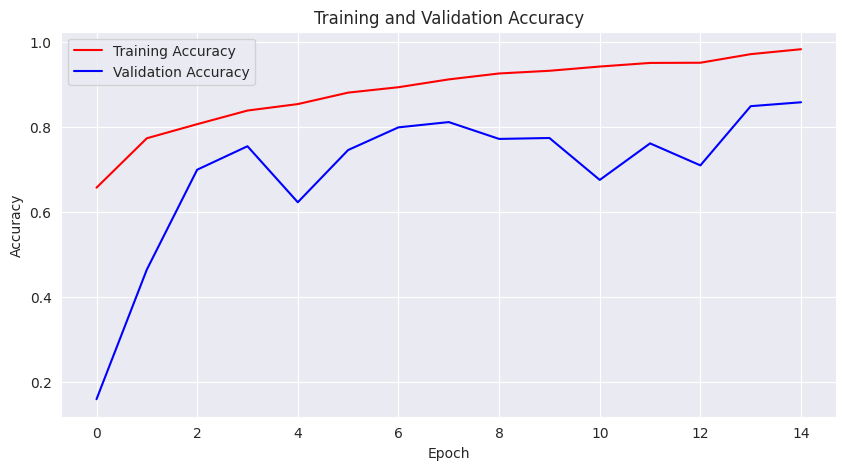

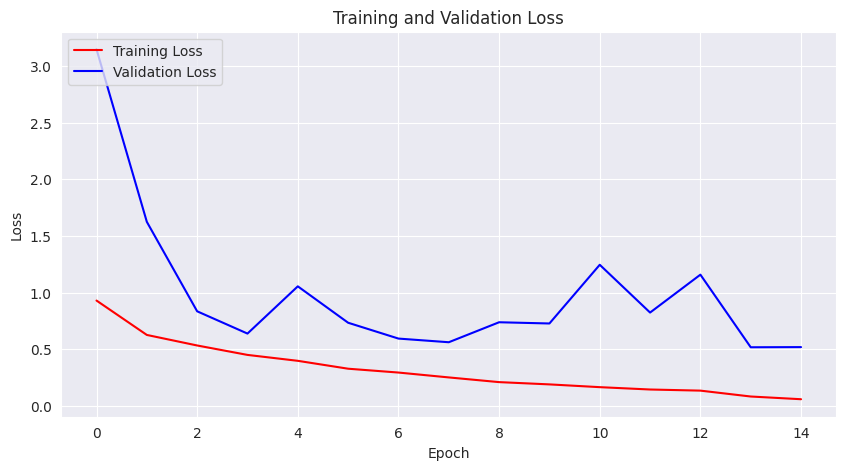

In [24]:
# Extract accuracy and loss from history object
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

116/116 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step


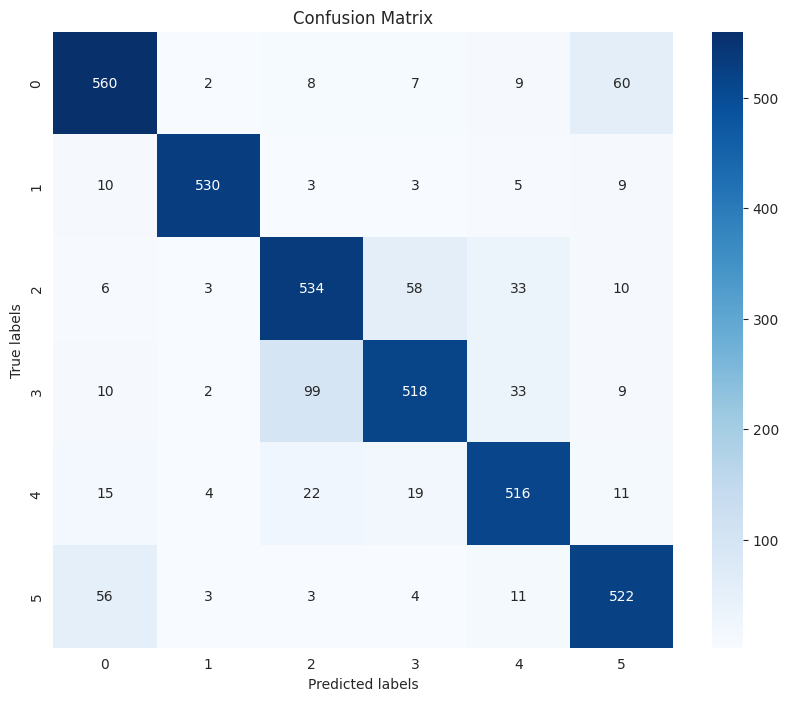

              precision    recall  f1-score   support

           0       0.85      0.87      0.86       646
           1       0.97      0.95      0.96       560
           2       0.80      0.83      0.81       644
           3       0.85      0.77      0.81       671
           4       0.85      0.88      0.86       587
           5       0.84      0.87      0.86       599

    accuracy                           0.86      3707
   macro avg       0.86      0.86      0.86      3707
weighted avg       0.86      0.86      0.86      3707



In [25]:
# Mendapatkan prediksi dari model
Y_pred = model1.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Mendapatkan label sebenarnya dari test generator
y_true = test_generator.classes

# Membuat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Menampilkan confusion matrix menggunakan seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Menampilkan classification report
print(classification_report(y_true, y_pred))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step


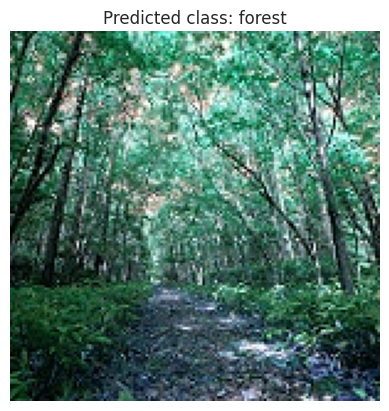

In [30]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt
import cv2
best_model = load_model('/content/Best_model1.keras')

# Function to make predictions
def predict_image(image_path):
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  img_array /= 255.0  # Normalize the image

  prediction = best_model.predict(img_array)
  predicted_class = np.argmax(prediction)

  class_labels = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street', 'rose']
  predicted_label = class_labels[predicted_class]

  return predicted_label

# Example usage
image_path = '/content/intel_image/dataset/forest/10010.jpg'
prediction = predict_image(image_path)
image_path = cv2.imread(image_path)
plt.imshow(image_path)
plt.title(f"Predicted class: {prediction}")
plt.axis('off')
plt.show()


#konversi model

In [32]:
#SAVE MODEL
save_path = 'saved_model/'
tf.saved_model.save(model1, save_path)

In [33]:
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()

# Save the TF-Lite model to a file
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)


Saved artifact at '/tmp/tmpf64hucka'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  139034208545680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034208549376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034208625312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034208627248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034208620736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034208623024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034230801856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034230804672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034230803088: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034230807488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139034230802032

In [38]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
      Successfully uninstalled packaging-24.1


In [56]:
!pip install tensorflowjs --upgrade

In [63]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    --output_node_names 'MobilenetV1/Predictions/Reshape_1' \
    /path/to/saved_model \
    /path/to/web_model

2024-09-07 00:01:11.420394: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:01:11.441890: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:01:11.447948: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 00:01:12.507704: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 959, in pip_main
    

In [64]:
!tensorflowjs_converter \
    --input_format = tf_saved_model \
    /content/mymodel/ \
    /content/modeltfjs

2024-09-07 00:02:02.214733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:02:02.235382: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:02:02.241610: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 00:02:03.287042: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: TensorFlow.js model converters. [-h]
                                       [--input_format {keras_keras,tf_saved_model,keras,keras_saved_model,tfjs_layers_model,tf_hub,tf_frozen_model}]
                                       [--outpu

In [65]:
!tensorflowjs_converter \
    --input_format tf_saved_model \
    /content/saved_model/ \
    /content/modeltfjs


2024-09-07 00:02:51.720617: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 00:02:51.752603: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 00:02:51.762416: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 00:02:53.538876: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
I0000 00:00:1725667376.423450   25426 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/b

In [66]:
import tensorflow as tf

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path='model.tflite')
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
image_path = '/content/intel_image/dataset/forest/10010.jpg'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0  # Normalize the image

# Set the input tensor
interpreter.set_tensor(input_details[0]['index'], img_array)

# Run inference
interpreter.invoke()

# Get the output tensor
output_data = interpreter.get_tensor(output_details[0]['index'])

# Get the predicted class
predicted_class = np.argmax(output_data)

# Print the predicted class
print(f"Predicted class: {predicted_class}")


Predicted class: 1


In [67]:
!pip freeze > requirements.txt
